# Analysis of data from B. Toner, taken at ALS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches

import os
import pandas as pd

from sklearn.linear_model import LinearRegression

from importlib import reload
import utils
utils = reload(utils)
from utils import *

import mantis_xray

import skimage

np.random.seed(42)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

# Data I/O

Run this block once at beginning of analysis to convert .xim files to one .tif file.

In [3]:
# def read_write_data_files(directory, new_fname):
#     datafiles = [fname for fname in os.listdir(directory) if fname.endswith('.xim')]
#     Data = []
#     for dfile in datafiles:
#         img = np.loadtxt(directory + dfile)
#         Data.append(img)
#     Data = np.array(Data)
#     # flip to be channels last
#     data_img = np.ones((Data.shape[1], Data.shape[2], Data.shape[0]))
#     for x in range(Data.shape[1]):
#         for y in range(Data.shape[2]):
#             data_img[x, y, :] = Data[:, x, y]
#     # save data to tiff file format
#     skimage.io.imsave(new_fname, data_img, plugin='tifffile')
    
# directory = "Data/ALS_Toner/71214098_FigS3/Aligned/"
# new_fname = "Data/ALS_Toner/71214098.tiff"
# read_write_data_files(directory, new_fname)

# directory = "Data/ALS_Toner/71214078_FigS4/Aligned/"
# new_fname = "Data/ALS_Toner/71214078.tiff"
# read_write_data_files(directory, new_fname)

Run this block once .tif files are written for subseqent loading of data.

In [4]:
data_img_98 = skimage.io.imread("Data/ALS_Toner/71214098.tiff")
data_img_78 = skimage.io.imread("Data/ALS_Toner/71214078.tiff")
Energy = np.loadtxt('Data/ALS_Toner/Energy.txt')

# Divide out I0

In [5]:
# Use pre-specified I0 (Thanks Matthew Marcus)
_, I0_78 = np.loadtxt("Data/ALS_Toner/71214078_FigS4/Aligned/i0.xsp").T
_, I0_98 = np.loadtxt("Data/ALS_Toner/71214098_FigS3/Aligned/i0.xsp").T

In [6]:
DATA = {}
keys = [78, 98]
I0s = [I0_78, I0_98]

for i, data_img in enumerate([data_img_78, data_img_98]):
    normalized_img = data_img
    for x in range(normalized_img.shape[0]):
        for y in range(normalized_img.shape[1]):
            normalized_img[x, y, :] = normalized_img[x, y, :] / I0s[i]

    normalized_img = -normalized_img
    normalized_img = normalized_img - np.min(normalized_img)
    normalized_img = normalized_img / np.max(normalized_img)
    DATA[keys[i]] = normalized_img

Text(0.5, 1.0, '98')

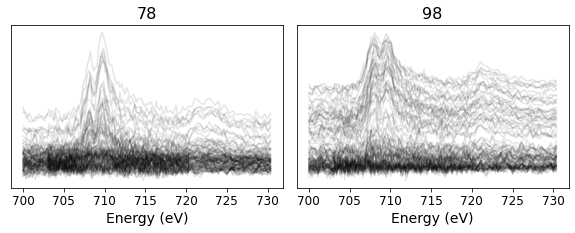

In [7]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=2)
plt.subplots_adjust(wspace=0.05)

i = 0
for x in range(50, 100):
    for y in range(50, 100):
        axes[0].plot(Energy, DATA[78][x, y, :], 'k', alpha=0.1)
        axes[1].plot(Energy, DATA[98][x, y, :], 'k', alpha=0.1)
        i = i + 1
        if i == 100:
            break
    if i >= 100:
        break
for ax in axes:
    ax.tick_params(labelsize=12)
    ax.set_yticks([])
    ax.set_xlabel('Energy (eV)', fontsize=14)
axes[0].set_title('78', fontsize=16)
axes[1].set_title('98', fontsize=16)

Text(0, 0.5, '98')

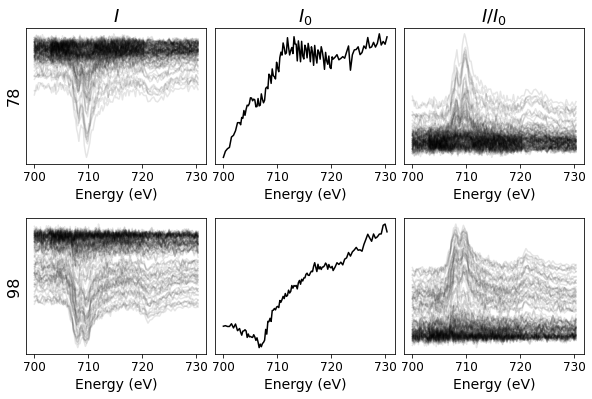

In [8]:
fig, axes = plt.subplots(figsize=(10, 6), ncols=3, nrows=2)
plt.subplots_adjust(wspace=0.05, hspace=0.4)

i = 0
for x in range(50, 100):
    for y in range(50, 100):
        axes[0, 0].plot(Energy, data_img_78[x, y, :], 'k', alpha=0.1)
        axes[1, 0].plot(Energy, data_img_98[x, y, :], 'k', alpha=0.1)
        
        axes[0, 2].plot(Energy, DATA[78][x, y, :], 'k', alpha=0.1)
        axes[1, 2].plot(Energy, DATA[98][x, y, :], 'k', alpha=0.1)
        i = i + 1
        if i == 100:
            break
    if i >= 100:
        break
        
axes[0, 1].plot(Energy, I0_78, 'k')
axes[1, 1].plot(Energy, I0_98, 'k')

for axl in axes:
    for ax in axl:
        ax.tick_params(labelsize=12)
        ax.set_yticks([])
        ax.set_xlabel('Energy (eV)', fontsize=14)

axes[0, 0].set_title('$I$', fontsize=18)
axes[0, 1].set_title('$I_0$', fontsize=18)
axes[0, 2].set_title('$I/I_0$', fontsize=18)

axes[0, 0].set_ylabel('78', fontsize=16)
axes[1, 0].set_ylabel('98', fontsize=16)

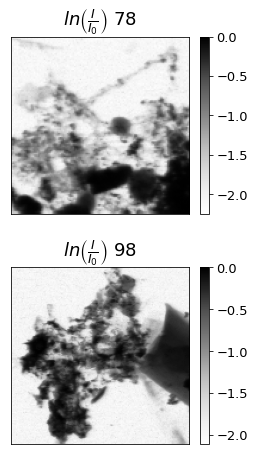

In [9]:
fig, axes = plt.subplots(figsize=(4, 7.5), nrows=2)
plt.subplots_adjust(hspace=0.3)

img = axes[0].imshow(np.log(np.flip(np.max(DATA[78], axis=2), axis=0)), cmap=plt.cm.Greys, aspect='auto')
cbar = plt.colorbar(img, ax=axes[0])
cbar.ax.tick_params(labelsize=13)

img = axes[1].imshow(np.log(np.flip(np.max(DATA[98], axis=2), axis=0)), cmap=plt.cm.Greys, aspect='auto')
cbar = plt.colorbar(img, ax=axes[1])
cbar.ax.tick_params(labelsize=13)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_title(r'$ln \left( \frac{I}{I_0} \right)$ 78', fontsize=18)
axes[1].set_title(r'$ln \left( \frac{I}{I_0} \right)$ 98', fontsize=18)
plt.show()

# Mantis

In [10]:
mantis_xray.__version__
# open the GUI by using 'python -m mantis_xray' in the command prompt

'3.1.13'

## Background subtract

In [11]:
# indices = [i for i, e in enumerate(Energy) if e < 704]

# for idx in [i for i, e in enumerate(Energy) if e > 716 and e < 718]:
#     indices.append(idx)

# for idx in [i for i, e in enumerate(Energy) if e > 726]:
#     indices.append(idx)

In [12]:
# def model_spectrum(params, x):
#     return params[0] * np.arctan(params[1] * (x - 708.65)) + params[2]\
#        #  + params[2] * np.arctan(params[3] * (x - 721.65)) + params[4]

# def bkgd_loss_function(params, x, ytrue, indices):    
#     yfit = model_spectrum(params, x)
#     sliced_yfit = np.array([yfit[i] for i in indices])
#     sliced_ytrue = np.array([ytrue[i] for i in indices])
#     error = mean_squared_error(sliced_yfit, sliced_ytrue)
#     return error

### Show example

In [13]:
# fig, ax = plt.subplots(figsize=(5, 4))
# img = ax.imshow(np.flip(np.max(DATA[98], axis=2), axis=0), cmap=plt.cm.viridis, aspect='auto')
# plt.colorbar(img)
# ax.scatter(21, 70, marker='o', c='w', s=15)
# plt.show()

In [14]:
# x = np.array(Energy)
# ytrue = normalized_img[70, 21]

# params_0 = np.zeros(3) + 0.01
# results = minimize(bkgd_loss_function, params_0, args=(x, ytrue, indices), method='SLSQP')
# background_atan = model_spectrum(results['x'], x)

# sliced_energy = np.array([Energy[i] for i in indices])
# sliced_spectrum = np.array([ytrue[i] for i in indices])

# m, b = np.polyfit(sliced_energy.T, sliced_spectrum.T, 1)
# background_lin = m * np.array(Energy) + b 

# a1, a2, b = np.polyfit(sliced_energy.T, sliced_spectrum.T, 2)
# background_poly = a1 * np.array(Energy)**2 + a2 * np.array(Energy) + b 

# Backgrounds = [background_atan, background_lin, background_poly]

In [15]:
# fig, axes = plt.subplots(figsize=(4 * 3, 2.6 * 2), ncols=3, nrows=2)
# plt.subplots_adjust(wspace=0.25, hspace=0.4)

# # titles = ['$\quad a*arctan(b(x - 708.65))$' + '\n' +
# #           '$+\; c*arctan(d(x - 721.65))$', '$ax + b$', '$ax^2 + bx + c$']
# titles = ['$\quad a*arctan(b(x - 708.65))$', '$ax + b$', '$ax^2 + bx + c$']
# for i, axl in enumerate(axes):
#     for j, ax in enumerate(axl):
#         ax.grid(axis='y')
#         ax.tick_params(length=8, width=1.2, labelsize=12)
# for i in range(3):
#     axes[0, i].plot(x, ytrue)
#     axes[0, i].plot(x, Backgrounds[i], '--')
#     axes[1, i].plot(x, ytrue - Backgrounds[i])
#     for idx in indices:
#         axes[0, i].axvline(Energy[idx], c=plt.cm.tab20(15), zorder=1, lw=5)
#     axes[0, i].set_title(titles[i], fontsize=15)
# plt.show()

# Mask

In [16]:
def get_mask(fname, width=150):
    file = open(fname, 'r')
    lines = file.readlines()
    file.close()
    # convert mask into np array of booleans
    feature_mask = []
    for i, line in enumerate(lines):
        processed_line = line.strip()
        processed_line = processed_line.replace('O', '0').replace(' ', '1')
        for i in range(width - len(processed_line)):
            processed_line = processed_line + '1'
        processed_line = np.array(list(processed_line), dtype=int)
        feature_mask.append(processed_line)
    feature_mask = np.flip(np.array(feature_mask), axis=0)
    return feature_mask

mask_files = ["Data/ALS_Toner/71214078_FigS4/Aligned/mask_file.msk",
              "Data/ALS_Toner/71214098_FigS3/Aligned/remove thick part.msk"]
Masks = {key: get_mask(mask_files[i], width=DATA[key].shape[0]) 
         for i, key in enumerate([78, 98])}

Text(0, 0.5, 'Mask')

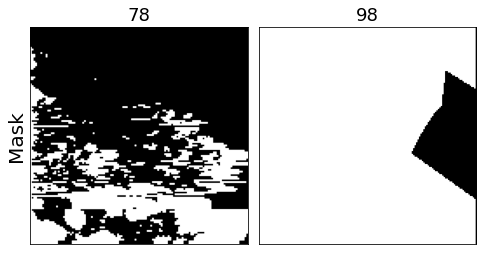

In [17]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
plt.subplots_adjust(wspace=0.05)
axes[0].imshow(Masks[78], cmap=plt.cm.Greys)
axes[1].imshow(Masks[98], cmap=plt.cm.Greys)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_title(78, fontsize=18)
axes[1].set_title(98, fontsize=18)
axes[0].set_ylabel('Mask', fontsize=20)

In [18]:
thresholds = {78: 0.25, 98: 0.25}

Filtered_Data_Img = {}
for key, mask in Masks.items():
    processed_img = DATA[key]
    tmp_mask = np.ones((processed_img.shape[0], processed_img.shape[1]))
    thresh_bool_arr = np.average(processed_img, axis=2) > thresholds[key]
    feat_bool_arr = mask == 1
    tmp_mask[thresh_bool_arr] = 0
    if key == 98:
        tmp_mask[feat_bool_arr] = 1
    
    filtered_data_dict = {(x, y): processed_img[x, y, :] 
                          for x in range(processed_img.shape[0]) 
                          for y in range(processed_img.shape[1])
                          if tmp_mask[x, y] == 0}
    Filtered_Data_Img[key] = filtered_data_dict
    Masks[key] = tmp_mask

Filtered_Data = {key: np.array(list(dty.values())) for key, dty in Filtered_Data_Img.items()}

Text(0, 0.5, 'Mask After\nThresholding')

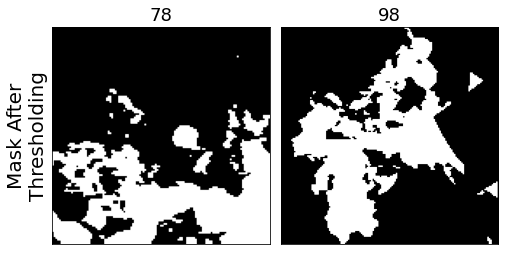

In [19]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
plt.subplots_adjust(wspace=0.05)
axes[0].imshow(np.flip(Masks[78], axis=0), cmap=plt.cm.Greys)
axes[1].imshow(np.flip(Masks[98], axis=0), cmap=plt.cm.Greys)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_title(78, fontsize=18)
axes[1].set_title(98, fontsize=18)
axes[0].set_ylabel('Mask After\nThresholding', fontsize=20)

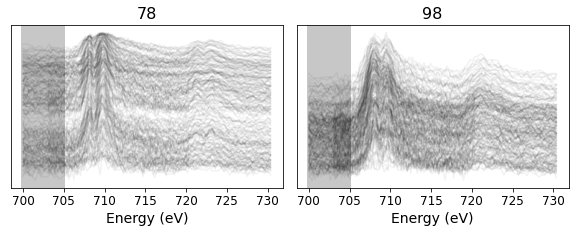

In [20]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=2)
plt.subplots_adjust(wspace=0.05)

for i in range(50, 2000, 10):
    axes[0].plot(Energy, Filtered_Data[78][i], 'k', alpha=0.05)
    axes[1].plot(Energy, Filtered_Data[98][i], 'k', alpha=0.05)

for ax in axes:
    ax.tick_params(labelsize=12)
    ax.set_yticks([])
    ax.set_xlabel('Energy (eV)', fontsize=14)
axes[0].set_title('78', fontsize=16)
axes[1].set_title('98', fontsize=16)

indices = [i for i, e in enumerate(Energy) if e < 705]
for i in range(2):
    for idx in indices:
        axes[i].axvline(Energy[idx], c=plt.cm.tab20(15), zorder=1, lw=5)

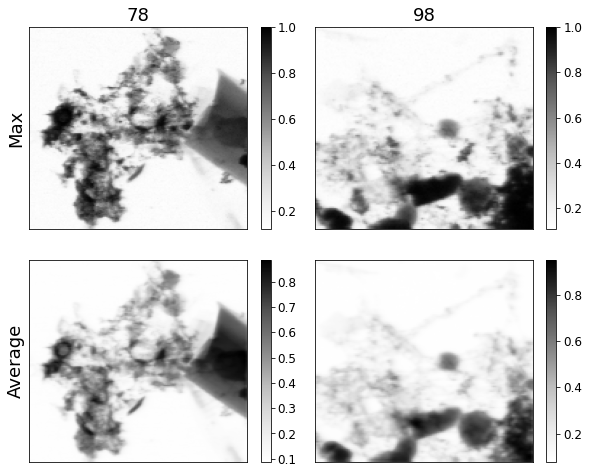

In [21]:
fig, axes = plt.subplots(figsize=(10, 8), ncols=2, nrows=2)
plt.subplots_adjust(wspace=0.05, hspace=0.15)

img = axes[0, 0].imshow(np.flip(np.max(DATA[98], axis=2), axis=0), 
                        cmap=plt.cm.Greys, aspect='auto')
cbar = plt.colorbar(img, ax=axes[0, 0])
cbar.ax.tick_params(labelsize=12)

img = axes[1, 0].imshow(np.flip(np.average(DATA[98], axis=2), axis=0), 
                        cmap=plt.cm.Greys, aspect='auto')
cbar = plt.colorbar(img, ax=axes[1, 0])
cbar.ax.tick_params(labelsize=12)

img = axes[0, 1].imshow(np.flip(np.max(DATA[78], axis=2), axis=0), 
                        cmap=plt.cm.Greys, aspect='auto')
cbar = plt.colorbar(img, ax=axes[0, 1])
cbar.ax.tick_params(labelsize=12)

img = axes[1, 1].imshow(np.flip(np.average(DATA[78], axis=2), axis=0), 
                        cmap=plt.cm.Greys, aspect='auto')
cbar = plt.colorbar(img, ax=axes[1, 1])
cbar.ax.tick_params(labelsize=12)

for axl in axes:
    for ax in axl:
        ax.set_xticks([])
        ax.set_yticks([])

axes[0, 0].set_title(r'78', fontsize=18)
axes[0, 1].set_title(r'98', fontsize=18)
axes[0, 0].set_ylabel('Max', fontsize=18)
axes[1, 0].set_ylabel('Average', fontsize=18)
plt.show()

# Background Subtraction

In [22]:
Processed_Data = {}
indices = [i for i, e in enumerate(Energy) if e < 704]

for key, normalized_img in DATA.items():
    processed_img = normalized_img.copy()

    background_subtract = True

    if background_subtract:
        for x in range(processed_img.shape[0]):
            for y in range(processed_img.shape[1]):        
#                 params_0 = np.zeros(3) + 0.01
#                 results = minimize(bkgd_loss_function, params_0, 
#                                    args=(np.array(Energy), processed_img[x, y], indices), method='SLSQP')
#                 if results['success'] == False:
#                     print('ahhhhhhhh')
#                 background = model_spectrum(results['x'], np.array(Energy))
                
#                 sliced_energy = np.array([Energy[i] for i in indices])
#                 sliced_spectrum = np.array([processed_img[x, y, i] for i in indices])
#                 m, b = np.polyfit(sliced_energy.T, sliced_spectrum.T, 1)
#                 background = m * np.array(Energy) + b 
                
                background = np.average([processed_img[x, y, i] for i in indices])
                
                processed_img[x, y, :] = processed_img[x, y, :] - background
                processed_img[x, y, :] = processed_img[x, y, :] / np.sum(processed_img[x, y, :])
        
    Processed_Data[key] = processed_img

In [23]:
Filtered_Data_Img = {}

for key, mask in Masks.items():
    processed_img = Processed_Data[key]
    filtered_data_dict = {(x, y): processed_img[x, y, :] 
                          for x in range(processed_img.shape[0]) 
                          for y in range(processed_img.shape[1])
                          if mask[x, y] == 0}
    Filtered_Data_Img[key] = filtered_data_dict

Filtered_Data = {key: np.array(list(dty.values())) for key, dty in Filtered_Data_Img.items()}

In [24]:
lower_thresholds = {78: -0.025, 98: -0.01}
upper_thresholds = {78: 0.08, 98: 0.05}
var_thresholds = {78: 0.001, 98: 0.01}

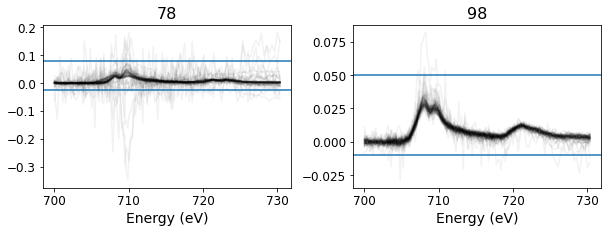

In [25]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=2)
plt.subplots_adjust(wspace=0.25)

for i in range(50, 850, 10):
    axes[0].plot(Energy, Filtered_Data[78][i], 'k', alpha=0.05)
    axes[1].plot(Energy, Filtered_Data[98][i], 'k', alpha=0.05)

for ax in axes:
    ax.tick_params(labelsize=12)
#     ax.set_yticks([])
    ax.set_xlabel('Energy (eV)', fontsize=14)
axes[0].set_title('78', fontsize=16)
axes[1].set_title('98', fontsize=16)

for i, key in enumerate([78, 98]):
    axes[i].axhline(lower_thresholds[key], c=plt.cm.tab20(0))
    axes[i].axhline(upper_thresholds[key], c=plt.cm.tab20(0))

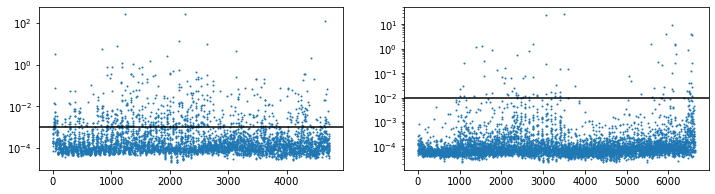

In [26]:
fig, axes = plt.subplots(figsize=(12, 3), ncols=2)
axes[0].plot(np.var(Filtered_Data[78], axis=1), 'o', markersize=1)
axes[1].plot(np.var(Filtered_Data[98], axis=1), 'o', markersize=1)
for ax in axes:
    ax.set_yscale('log')
for i, key in enumerate([78, 98]):
    axes[i].axhline(var_thresholds[key], c='k')

In [27]:
Filtered_Data_Img = {}

for key, mask in Masks.items():
    processed_img = Processed_Data[key]
    
    temp_mask = mask.copy()
    bool_arr = np.min(processed_img, axis=2) < lower_thresholds[key]
    temp_mask[bool_arr] = 1
    bool_arr2 = np.max(processed_img, axis=2) > upper_thresholds[key]
    temp_mask[bool_arr2] = 1
    bool_arr3 = np.var(processed_img, axis=2) > var_thresholds[key]
    temp_mask[bool_arr3] = 1
    
    filtered_data_dict = {(x, y): processed_img[x, y, :] 
                          for x in range(processed_img.shape[0]) 
                          for y in range(processed_img.shape[1])
                          if temp_mask[x, y] == 0}
    
    Masks[key] = temp_mask
    Filtered_Data_Img[key] = filtered_data_dict

Filtered_Data = {key: np.array(list(dty.values())) for key, dty in Filtered_Data_Img.items()}

Text(0.5, 1.0, '98')

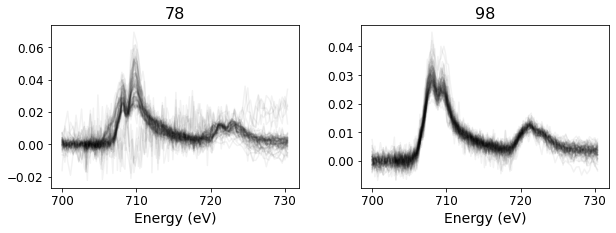

In [28]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=2)
plt.subplots_adjust(wspace=0.25)

for i in range(50, 850, 10):
    axes[0].plot(Energy, Filtered_Data[78][i], 'k', alpha=0.05)
    axes[1].plot(Energy, Filtered_Data[98][i], 'k', alpha=0.05)

for ax in axes:
    ax.tick_params(labelsize=12)
#     ax.set_yticks([])
    ax.set_xlabel('Energy (eV)', fontsize=14)
axes[0].set_title('78', fontsize=16)
axes[1].set_title('98', fontsize=16)

Text(0, 0.5, 'Mask After\nThresholding')

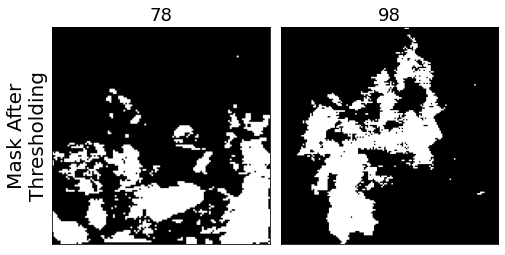

In [29]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
plt.subplots_adjust(wspace=0.05)
axes[0].imshow(np.flip(Masks[78], axis=0), cmap=plt.cm.Greys)
axes[1].imshow(np.flip(Masks[98], axis=0), cmap=plt.cm.Greys)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_title(78, fontsize=18)
axes[1].set_title(98, fontsize=18)
axes[0].set_ylabel('Mask After\nThresholding', fontsize=20)

# Analysis

In [30]:
def make_scree_plot(data, n=5, threshold=0.95, color=plt.cm.Dark2(2), xy=(0.7, 0.3)):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pca = PCA()
    pca_components = pca.fit_transform(data)

    n_components = 0
    x = np.arange(n) + 1
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]
    for i, val in enumerate(cdf):
        if val > threshold:
            text = f"It takes {i + 1} PCs to explain\n{int(threshold*100)}% variance."
            print(text)
            ax.text(xy[0], xy[1], text, va='center', ha='center', fontsize=20,
                    transform=ax.transAxes)
            n_components = i + 1
            break

    ax.plot(x, cdf, 's-', markersize=12, fillstyle='none', color=color, linewidth=3)
    ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)
    xticks = np.arange(n) + 1
    
    plt.xticks(xticks, fontsize=18)
    plt.yticks(fontsize=18)
    #plt.ylim(min(cdf) - 0.005, 1.00)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xlabel('Number of Parameters', fontsize=22)
    plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
    ax.tick_params(direction='in', width=2, length=8)
    
    return n_components

In [31]:
Scaled_Data = {}
for key in Filtered_Data.keys():
    scaled_data = np.array(Filtered_Data[key]).copy()
#     scaled_data = scaled_data - np.min(scaled_data)
#     scaled_data = scaled_data / np.max(scaled_data)
    Scaled_Data[key] = scaled_data

It takes 6 PCs to explain
65% variance.
It takes 5 PCs to explain
48% variance.


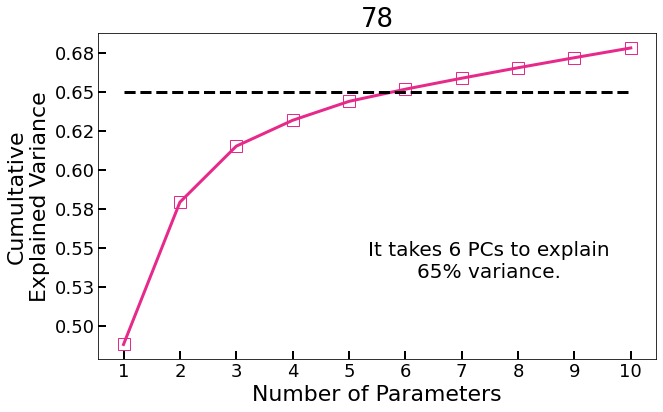

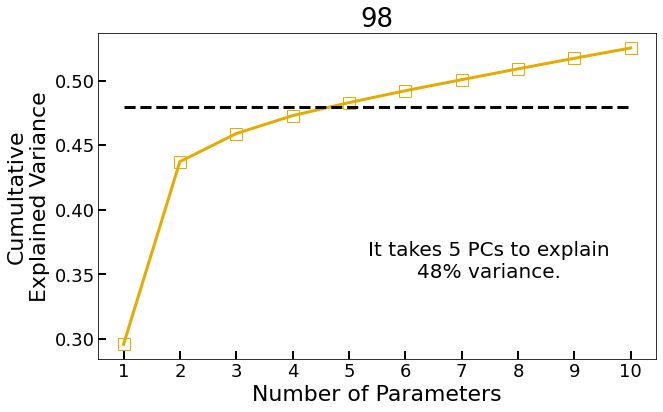

In [32]:
colors = [plt.cm.Dark2(3), plt.cm.Dark2(5)]

n_components_78 = make_scree_plot(Scaled_Data[78], n=10, threshold=0.65, color=colors[0])
plt.title('78', fontsize=26)

n_components_98 = make_scree_plot(Scaled_Data[98], n=10, threshold=0.48, color=colors[1])
plt.title('98', fontsize=26)

N_comps = {78: n_components_78, 98: n_components_98}

In [33]:
Recon = {}
Proj = {}
PCA_dict = {}
for key, n_components in N_comps.items():
    pca = PCA(n_components=n_components)
    pca = pca.fit(Scaled_Data[key])
    projections = pca.transform(Scaled_Data[key])
    reconstructions = projections @ pca.components_ + pca.mean_
    Recon[key] = reconstructions
    Proj[key] = projections
    PCA_dict[key] = pca

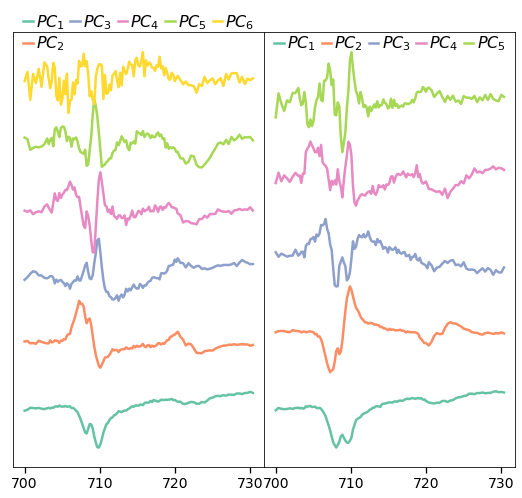

In [34]:
fig, axes = plt.subplots(figsize=(9, 8), ncols=2)
plt.subplots_adjust(wspace=0.)
for i, pc in enumerate(PCA_dict[78].components_):
    axes[0].plot(Energy, pc + i * 0.5, label=f'$PC_{i + 1}$', color=plt.cm.Set2(i), linewidth=2.5)
for i, pc in enumerate(PCA_dict[98].components_):
    axes[1].plot(Energy, pc + i * 0.5, label=f'$PC_{i + 1}$', color=plt.cm.Set2(i), linewidth=2.5)
for ax in axes:
    ax.legend(fontsize=16, bbox_to_anchor=(0.5, 0.92), handlelength=.6, columnspacing=0.35,
              labelspacing=.15, handletextpad=0.2, ncol=5, loc='lower center', framealpha=0)
    ax.set_yticks([])
    ax.tick_params(width=1.3, length=6, labelsize=14)

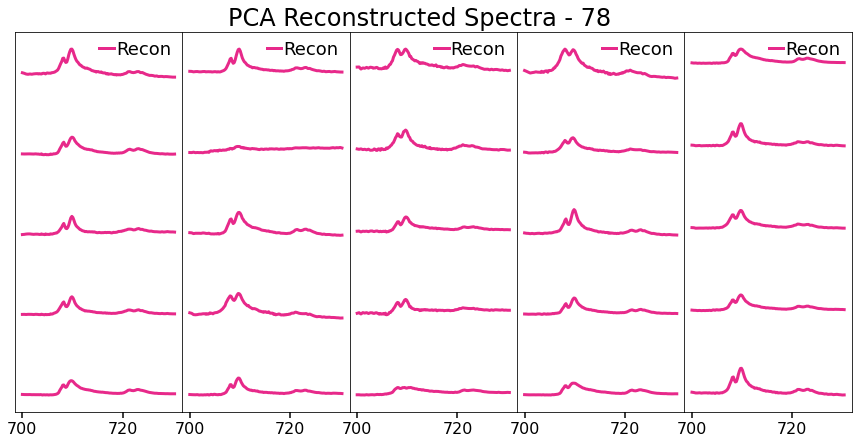

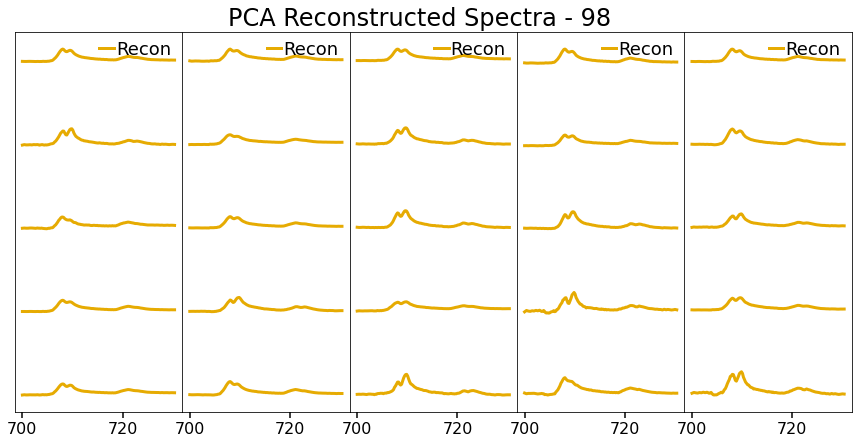

In [35]:
for k, key in enumerate(list(Recon.keys())):
    ncols = 5
    fig, axes = plt.subplots(figsize=(3 * ncols, 7), ncols=ncols)
    plt.subplots_adjust(wspace=0.)
    for col in range(ncols):
        ax = axes[col]
        random_indices = np.random.choice(np.arange(Proj[key].shape[0]), size=5, replace=False)
        for i, idx in enumerate(random_indices):
            bottom = i * 0.2
            if i == 0:
#                 ax.plot(Energy, Filtered_Data[key][idx] + i , c='k', alpha=0.5, label='Data')
                ax.plot(Energy, Recon[key][idx] + bottom, c=colors[k], label='Recon', lw=3)
            else:            
#                 ax.plot(Energy, Filtered_Data[key][idx] + i, c='k', alpha=0.5)
                ax.plot(Energy, Recon[key][idx] + bottom, c=colors[k], lw=3)
        ax.tick_params(length=6, width=1.5, labelsize=16)
        ax.grid(axis='y')
        ax.set_yticks([])
        ax.legend(fontsize=18, framealpha=0, handlelength=.8, labelspacing=.1, handletextpad=0.12,
                  loc=1, bbox_to_anchor=(1.03, 1.02))

    plt.suptitle(f'PCA Reconstructed Spectra - {key}', fontsize=24, y=0.93)
    plt.show()

In [36]:
def get_cluster_avgs(spectra_dict, clusterizer):
    clusters = {i: [] for i in np.unique(clusterizer.labels_)}

    for i, key in enumerate(list(spectra_dict.keys())):
        spectrum = spectra_dict[key]
        color = clusterizer.labels_[i]
        clusters[color].append(spectrum)

    cluster_avgs = {key: np.average(clusters[key], axis=0) for key in list(clusters.keys())}
    return cluster_avgs

In [37]:
DRs = ['UMAP', 'PCA']
Reduced_spaces = {78: [], 98: []}
Clusterizers = {78: [], 98: []}
Cluster_avgs = {78: [], 98: []}

N_neighbors = [6, 4] # [5, 5]
N_clusters = [3, 3]

for i, key in enumerate([78, 98]):
    print(key)
    for DR in DRs:
        if DR == 'UMAP':
            n_neighbors = N_neighbors[i]
            reducer = umap.UMAP(random_state=42, n_components=2,
                                n_neighbors=n_neighbors, min_dist=0)
            reduced_space = reducer.fit_transform(Proj[key])
            clusterizer = DBSCAN(eps=.8, min_samples=5).fit(reduced_space)
            cluster_avgs = get_cluster_avgs(Filtered_Data_Img[key], clusterizer)
        else:
            n_clusters = N_clusters[i]
            reduced_space = Proj[key]
            clusterizer = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_space)
            cluster_avgs = get_cluster_avgs(Filtered_Data_Img[key], clusterizer)

        Reduced_spaces[key].append(reduced_space)
        Clusterizers[key].append(clusterizer)
        Cluster_avgs[key].append(cluster_avgs)
        print(f'There are {len(np.unique(clusterizer.labels_))} unique clusters in {DR}.')

78
There are 4 unique clusters in UMAP.
There are 3 unique clusters in PCA.
98
There are 4 unique clusters in UMAP.
There are 3 unique clusters in PCA.


In [38]:
Colors = {78: [], 98: []}
Cluster_colors = {78: [[], []], 98: [[], []]}

for key in [78, 98]:
    for i, DR in enumerate(DRs):
        if i == 1:
            offset = 4
            cmap = plt.cm.tab10
        else:
            offset = 0
            cmap = plt.cm.Set2
        Colors[key].append([cmap(c + offset) for c in Clusterizers[key][i].labels_])
        Cluster_colors[key][i] = [cmap(c + offset) for c in np.unique(Clusterizers[key][i].labels_)]

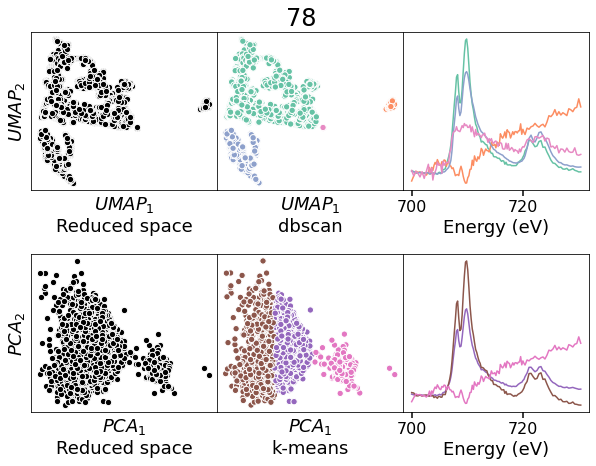

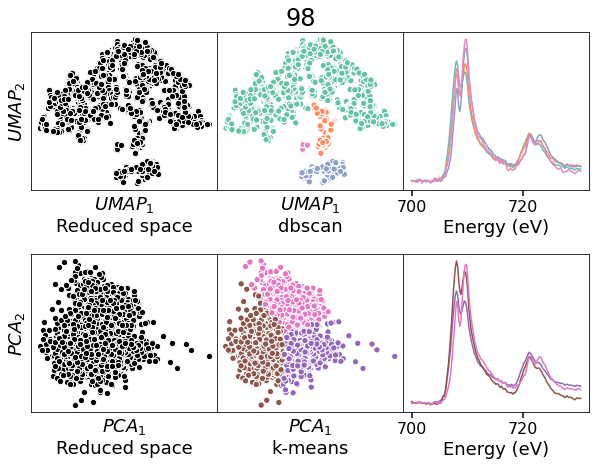

In [39]:
for key in [78, 98]:

    fig, axes = plt.subplots(figsize=(10, 7), ncols=3, nrows=2)
    plt.subplots_adjust(wspace=0, hspace=0.4)

    for i, DR in enumerate(DRs):
        colors = Colors[key][i]

        axes[i, 0].scatter(Reduced_spaces[key][i][:, 0], Reduced_spaces[key][i][:, 1], fc='k', ec='w', s=40)
        axes[i, 1].scatter(Reduced_spaces[key][i][:, 0], Reduced_spaces[key][i][:, 1], c=colors, ec='w', s=40)

        for j, pl in enumerate(Cluster_avgs[key][i].values()):
            axes[i, 2].plot(Energy, pl, c=Cluster_colors[key][i][j])

        for j, ax in enumerate(axes[i]):
            if j != 2:
                ax.set_xticks([])
                if j == 0:
                    ax.set_ylabel(f'${DR}_2$', fontsize=18)
                    ax.set_xlabel(f'${DR}_1$\nReduced space', fontsize=18)
                else:
                    if DR == 'UMAP':
                        clustering = 'dbscan'
                    else:
                        clustering = 'k-means'
                    ax.set_xlabel(f'${DR}_1$\n{clustering}', fontsize=18)
            else:
                ax.tick_params(length=6, width=1.5, labelsize=16)
                ax.set_xlabel(f'Energy (eV)', fontsize=18)
            ax.set_yticks([])

    plt.suptitle(key, fontsize=24, y=0.93)
    plt.show()

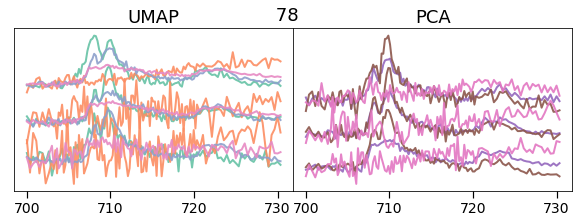

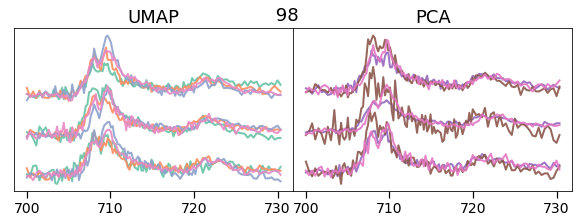

In [55]:
for key in [78, 98]:
    fig, axes = plt.subplots(figsize=(10, 3), ncols=2)
    plt.subplots_adjust(wspace=0)
    for i, DR in enumerate(DRs):
        labels = Clusterizers[key][i].labels_
        for cluster in np.unique(labels):
            indices = [idx for idx, l in enumerate(labels) if l == cluster]
            random_selection = np.random.choice(indices, size=3, replace=True)
            spectra = [Scaled_Data[key][idx] for idx in random_selection]
            color = Cluster_colors[key][i][cluster]
            for s, x in enumerate(spectra):
                axes[i].plot(Energy, x + s * 0.03, c=color, linewidth=2, alpha=0.9)
        axes[i].set_yticks([])
        axes[i].tick_params(length=7, width=1.2, labelsize=14)
        axes[i].set_title(DR, fontsize=18)
    plt.suptitle(f' ' + str(key), fontsize=18)

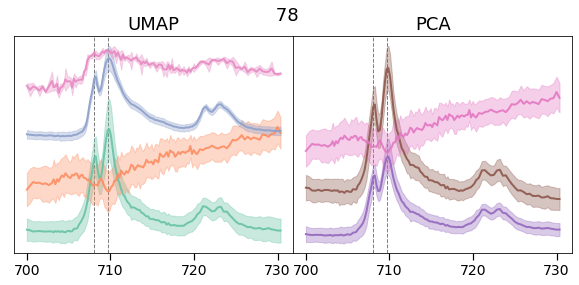

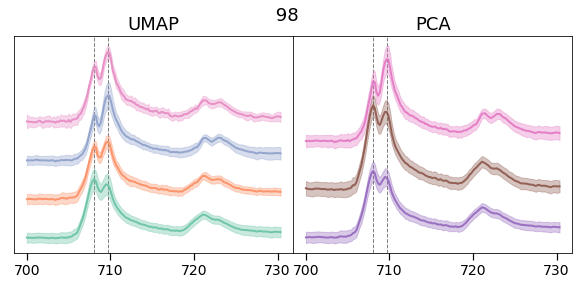

In [71]:
for key in [78, 98]:
    fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
    plt.subplots_adjust(wspace=0)
    for i, DR in enumerate(DRs):
        labels = Clusterizers[key][i].labels_
        for cluster in np.unique(labels):
            indices = [idx for idx, l in enumerate(labels) if l == cluster]
            spectra = [Scaled_Data[key][idx] for idx in indices]
            color = Cluster_colors[key][i][cluster]
            axes[i].plot(Energy, np.average(spectra, axis=0) + cluster * 0.02, c=color, linewidth=2, alpha=0.9)
            axes[i].fill_between(Energy, np.average(spectra, axis=0) + np.std(spectra, axis=0) + cluster * 0.02,
                                 np.average(spectra, axis=0) - np.std(spectra, axis=0) + cluster * 0.02, 
                                 color=color, alpha=0.35)
        axes[i].set_yticks([])
        axes[i].tick_params(length=7, width=1.2, labelsize=14)
        axes[i].set_title(DR, fontsize=18)
        axes[i].axvline(708, linewidth=1, c='gray', linestyle='--', zorder=0)
        axes[i].axvline(709.7, linewidth=1, c='gray', linestyle='--', zorder=0)
    plt.suptitle(f' ' + str(key), fontsize=18)

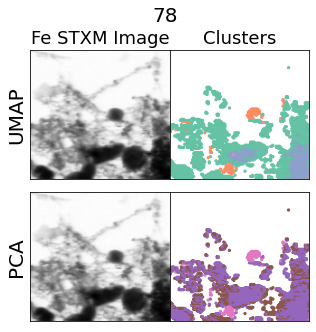

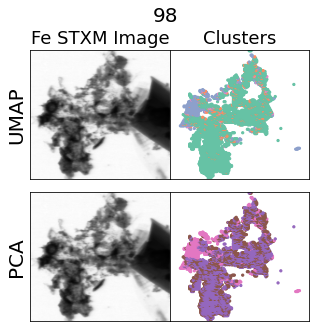

In [42]:
for key in [78, 98]:
    
    fig, axes = plt.subplots(figsize=(5, 5), ncols=2, nrows=2)
    plt.subplots_adjust(wspace=0.0, hspace=0.1)

    filtered_img = np.ma.masked_array(np.log(np.max(Processed_Data[key], axis=2)), mask=Masks[key])
    pts = np.array(list(Filtered_Data_Img[key].keys()))

    for i, DR in enumerate(DRs):
        colors = Colors[key][i]
        
        axes[i, 0].imshow(np.log(np.flip(np.average(DATA[key], axis=2), axis=0)), aspect='auto', 
                          cmap=plt.cm.Greys, origin='upper')
        axes[i, 1].scatter(pts[:, 1], pts[:, 0], s=5, marker='o', color=colors, lw=1, ec=colors)
        axes[i, 1].set_xlim(axes[i, 0].get_xlim())
        axes[i, 1].set_ylim(axes[i, 0].get_ylim()[1], axes[i, 0].get_ylim()[0])
        
        if i == 0:
            axes[i, 0].set_title('Fe STXM Image', fontsize=18)
            axes[i, 1].set_title(f'Clusters', fontsize=18)

        axes[i, 0].set_ylabel(DR, fontsize=20)

    for axl in axes:
        for ax in axl:
            pass
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.suptitle(key, fontsize=20, y=1)
    plt.show()

In [43]:
# pts = np.array(list(Filtered_Data_Img[78].keys()))

# fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
# plt.subplots_adjust(wspace=0)

# for pt in pts:
#     x, y = pt
#     axes[0].plot(y, x, 'o', markersize=1, c='k')

# print('meh')
# c = 0
# for x in range(Masks[78].shape[0]):
#     for y in range(Masks[78].shape[1]):
#         if Masks[78][x, y] == 0:
#             if (x, y) in pts:
#                 c += 1
#             axes[1].plot(y, x, 'o', markersize=1, c='k')

# for ax in axes:
#     ax.set_xticks([])
#     ax.set_yticks([])
# print(c, pts.shape[0], np.sum(Masks[78] == 0))

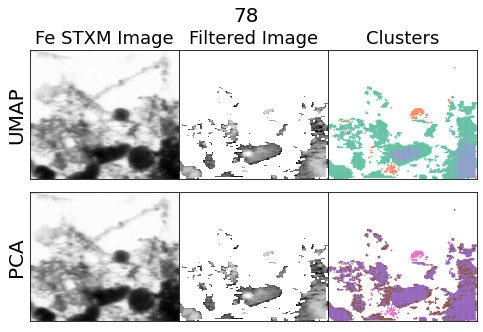

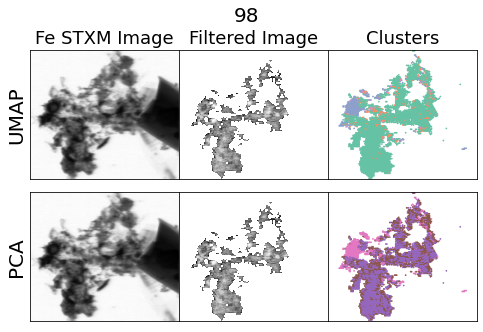

In [44]:
for key in [78, 98]:
    
    fig, axes = plt.subplots(figsize=(8, 5), ncols=3, nrows=2)
    plt.subplots_adjust(wspace=0.0, hspace=0.1)

    filtered_img = np.ma.masked_array(np.log(np.max(Processed_Data[key], axis=2)), mask=Masks[key])    
    pts = np.array(list(Filtered_Data_Img[key].keys()))

    for i, DR in enumerate(DRs):
        colors = Colors[key][i]
        
        axes[i, 0].imshow(np.log(np.flip(np.average(DATA[key], axis=2), axis=0)), aspect='auto', 
                          cmap=plt.cm.Greys, origin='upper')
        axes[i, 1].imshow(np.flip(filtered_img, axis=0), aspect='auto', cmap=plt.cm.Greys, origin='upper')
        axes[i, 2].scatter(pts[:, 1], pts[:, 0], s=0.5, marker='o', color=colors, lw=1, ec=colors)
        axes[i, 2].set_xlim(axes[i, 0].get_xlim())
        axes[i, 2].set_ylim(axes[i, 0].get_ylim()[1], axes[i, 0].get_ylim()[0])
        
        if i == 0:
            axes[i, 0].set_title('Fe STXM Image', fontsize=18)
            axes[i, 1].set_title('Filtered Image', fontsize=18)
            axes[i, 2].set_title(f'Clusters', fontsize=18)

#         axes[i, 3].set_title('Overlayed Image', fontsize=20)
#         axes[i, 3].imshow(np.flip(filtered_img, axis=0), aspect='auto', cmap=plt.cm.Greys, origin='upper')
#         axes[i, 3].scatter(pts[:, 1], -pts[:, 0] + 150, s=5, marker='o', color=colors, lw=0, alpha=0.6)

        axes[i, 0].set_ylabel(DR, fontsize=20)

    for axl in axes:
        for ax in axl:
            pass
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.suptitle(key, fontsize=20, y=1)
    plt.show()

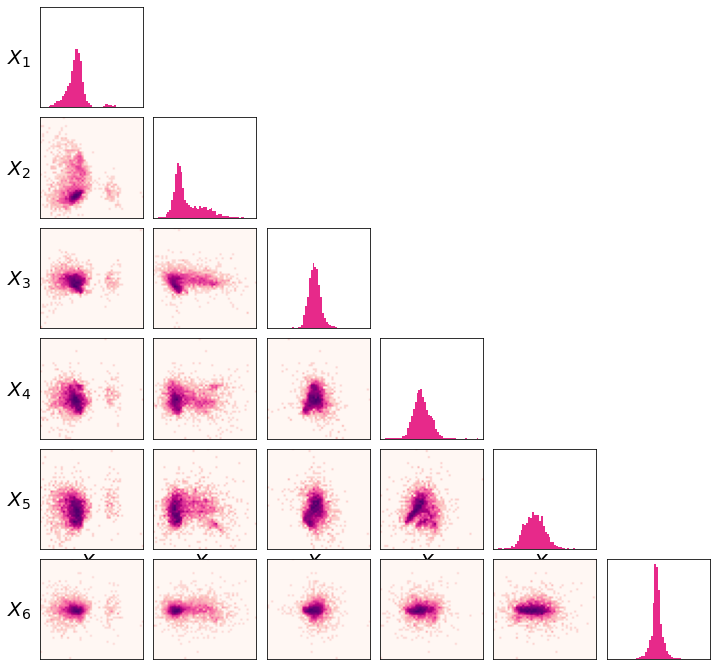

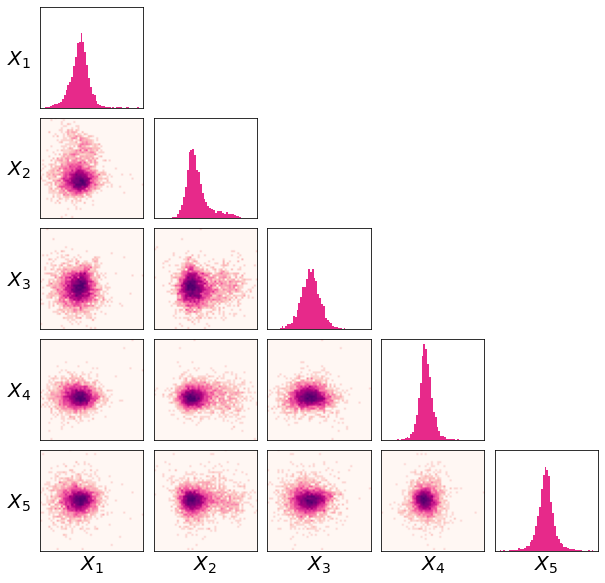

In [45]:
def make_triangle_plot(plot, data, color=plt.cm.Dark2(3), bins=50, tolerance=0.8, cmap=plt.cm.RdPu):
    
    n_dimensions = data.shape[1]
    fig, axes = plot

    for i in np.arange(n_dimensions):
        for j in np.arange(n_dimensions):
            ax = axes[i, j]
            if i == j:
                ax.hist(data[:, i], color=color, bins=bins)
                ax.set_xticks([])
                ax.set_yticks([])
            elif j < i:
                heatmap, xedges, yedges = np.histogram2d(data[:, j],
                                                         data[:, i],
                                                         bins=bins)
                extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
                ax.imshow(np.log(heatmap.T + tolerance), extent=extent, origin='lower', aspect='auto',
                          cmap=cmap)
                
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.axis('off')

            if j == 0:
                ax.set_ylabel(f'$X_{i + 1}$', fontsize=20, loc="center", rotation="horizontal")
                ax.yaxis.set_label_coords(-0.2, 0.37)
            if i == n_components - 1:
                ax.set_xlabel(f'$X_{j + 1}$', fontsize=20)

    max_y = 0
    for i in np.arange(n_dimensions):
        ax = axes[i, i]
        y_lim = ax.get_ylim()[1]
        if y_lim > max_y:
            max_y = y_lim
    for i in np.arange(n_dimensions):
        ax = axes[i, i]
        ax.set_ylim(0, max_y)
        
n_dimensions = Proj[78].shape[1]
fig, axes = plt.subplots(figsize=(2 * n_dimensions, 2 * n_dimensions),
                         ncols=n_dimensions, nrows=n_dimensions)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
make_triangle_plot((fig, axes), Proj[78])

n_dimensions = Proj[98].shape[1]
fig, axes = plt.subplots(figsize=(2 * n_dimensions, 2 * n_dimensions),
                         ncols=n_dimensions, nrows=n_dimensions)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
make_triangle_plot((fig, axes), Proj[98])